In [11]:
from yodapy.datasources import OOI
from yodapy.utils import set_credentials_file

ooi = OOI()
ooi.filter(region="cabled",site="oregon slope base shallow profiler",instrument="RS01SBPS-SF01A-2A-CTDPFA102")
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [12]:
begin = "2017-01-01"
end = "2017-12-31"
d = ooi.request_data(
        limit = 20000,
        data_type = "netcdf")

In [2]:
# oh wow it worked!
import xarray as xr

#with xr.open_dataset("C:/users/ganzk/desktop/notebooks/dev_notebooks/keenan/test.nc") as d:
frame = []
with xr.open_dataset("test2.nc") as d:
    frame = d.to_dataframe()
    print(frame.columns.values)

['time' 'deployment' 'id' 'conductivity' 'driver_timestamp' 'ext_volt0'
 'ingestion_timestamp' 'internal_timestamp' 'port_timestamp'
 'preferred_timestamp' 'pressure' 'pressure_temp' 'provenance'
 'temperature' 'seawater_temperature' 'seawater_pressure'
 'seawater_conductivity' 'practical_salinity' 'corrected_dissolved_oxygen'
 'density' 'seawater_temperature_qc_executed'
 'seawater_temperature_qc_results' 'seawater_pressure_qc_executed'
 'seawater_pressure_qc_results' 'seawater_conductivity_qc_executed'
 'seawater_conductivity_qc_results'
 'corrected_dissolved_oxygen_qc_executed'
 'corrected_dissolved_oxygen_qc_results' 'density_qc_executed'
 'density_qc_results' 'practical_salinity_qc_executed'
 'practical_salinity_qc_results' 'lat' 'lon']


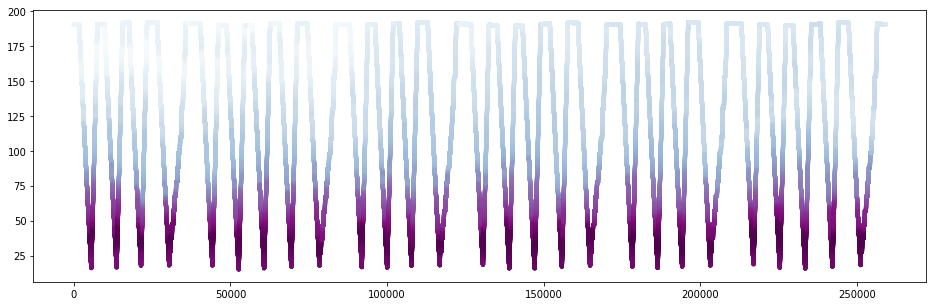

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors

t = frame["seawater_temperature"]
fig = plt.figure(figsize=(16,5))
plt.scatter(frame.index,frame["seawater_pressure"],s=10,c=frame["corrected_dissolved_oxygen"],cmap=plt.get_cmap("BuPu"))